<a href="https://colab.research.google.com/github/lakshmipriyaanand/nn-zero-to-hero-andrej-notes/blob/main/Micrograd_from_scratch_LP_Part2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Installing Micrograd

In [2]:
pip install micrograd

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
#Derivative of a simple function with one input

def f(x):
  return 3*x**2 - 4*x +5

In [5]:
f(3.0)

20.0

In [6]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

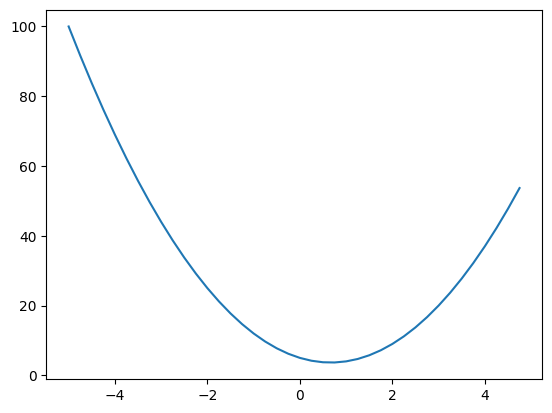

In [7]:
plt.plot(xs,ys)

In [8]:
h=0.00000001
x=2/3
(f(x + h) - f(x))/h

0.0

In [9]:
from micrograd.engine import Value

a = Value(-4.0)
b = Value(2.0)
c = a + b
d = a * b + b**3
c += c + 1
c += 1 + c + (-a)
d += d * 2 + (b + a).relu()
d += 3 * d + (b - a).relu()
e = c - d
f = e**2
g = f / 2.0
g += 10.0 / f
print(f'{g.data:.4f}') # prints 24.7041, the outcome of this forward pass
g.backward()
print(f'{a.grad:.4f}') # prints 138.8338, i.e. the numerical value of dg/da
print(f'{b.grad:.4f}') # prints 645.5773, i.e. the numerical value of dg/db

24.7041
138.8338
645.5773


In [10]:
#lets get more complex
a=2.0
b=-3.0
c=10.0
d=a*b+c
print(d)

4.0


In [11]:
h=0.0001

#inouts
a= 2.0
b= -3.0
c= 10.0

d1 = a*b+c
c+=h
d2 = a*b+c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [12]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data,n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [60]:
#Initialising class value

class Value:
  def __init__(self,data,_children=(),_op='',label=''):
    self.data=data
    self._prev=set(_children)
    self._op=_op
    self.grad= 0.0 #Default basic value is 0.0 - initialized
    self.label = label
    self._backward = lambda: None #Default it is none lambda function (leaf node)

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data + other.data,(self,other),'+')
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)
    out = Value(self.data * other.data,(self,other),'*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __pow__(self,other):
    assert isinstance(other,(int,float)), "only supporting int/float powers for now"
    out = Value(self.data**other,(self,),f'**{other}')
    def _backward():
      self.grad += (other * self.data**(other-1)) * out.grad
    out._backward = _backward
    return out

  def __rmul__(self,other):  #Does other * self
    return self * other

  def __truediv__(self,other): #self/other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self,other): #self - other
    return self + (-other)

  def __radd__(self,other): #other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
    out = Value(t,(self, ),'tanh')
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x),(self,),'exp')
    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward
    return out

  def backward(self): #Declaring automatic gradient value provider function instead of manual calculation
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [14]:
#If we give a = Value(2.0) , a+1 . It considers self=a and other=1. And tries to perform addition. But other=1 is not valid.
#So, we are adding "isinstance" and checking whether other is a value, if not, it tries to change it to Value

#Also if we try , 2+a or 2*a , it will throw the error, as python usually runs like 2.__mul__(a).
#So for this issue , python allows us to define something call __rmul__().
#If a python can't do 2*a , our python checks if any rmul is defined and rmul just swaps the position and does a*2.

2 * a

4.0

#Breaking the Tanh function

In [15]:
#We added exponential function to Value class so trying that out
y = Value(2.0)
y.exp() #e_power_y

Value(data=7.38905609893065)

In [16]:
#Trying our division functionalities
a = Value(2.0)
b = Value(3.0)
a/b #We get TypeError as unsupported operand without division function

Value(data=0.6666666666666666)

In [17]:
a ** 3

Value(data=8.0)

In [18]:
a - b

Value(data=-1.0)

In [19]:
x = -a
x

Value(data=-2.0)

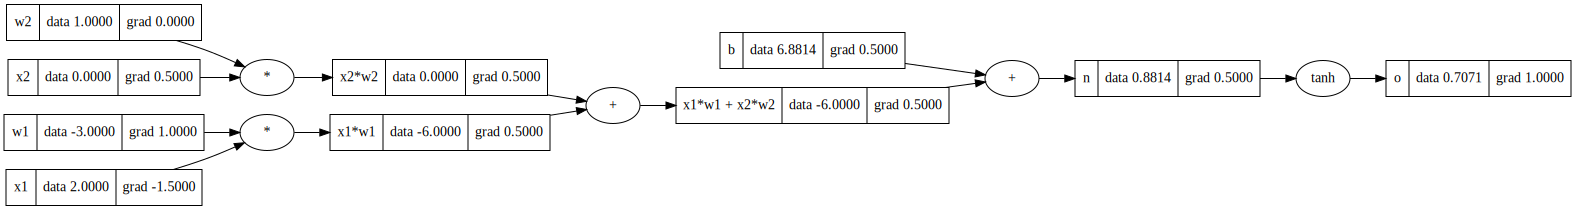

In [20]:
##Tanh implementation using basic example


# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

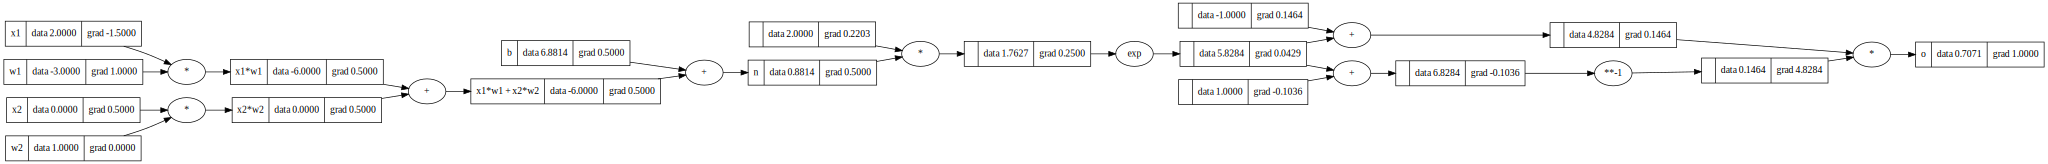

In [21]:
#Tanh implementation without using tanh function (elaborate formula)

# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

#----- Formula ----
e = (2*n).exp()
o = (e-1)/(e+1)

o.label = 'o'
o.backward()
draw_dot(o)

#Implementation of tanh using pytorch API - which is used in production

We usually give scalar values as numberical inputs to our previous scenarios. But here in Pytorch those are mostly about tensors.

Tensors are n-dimensional array of scalars. So mostly we try to convert our input scalar to tensor ( a tensor with just a single element )

In [22]:
import torch

In [23]:

x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [24]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [25]:
o.item()
#o.data.item() -- Gives same result

0.7071066904050358

#Basic Tensor Functionalities

In [26]:
 t = torch.Tensor([[1,2,3],[4,5,6]]) #Tensor matrix example
 t

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [27]:
np.array([[1,2,3],[4,5,6]]) #Similar to numpy array

array([[1, 2, 3],
       [4, 5, 6]])

In [28]:
t.shape

torch.Size([2, 3])

In [29]:
torch.randn(2,7)

tensor([[-1.0894, -1.1428, -0.5271, -0.1255, -1.0813, -2.3294,  1.9080],
        [-0.1780, -1.3655,  1.9394, -0.7739,  0.5427,  0.4738,  0.5893]])

In [30]:
torch.zeros([2,3])

tensor([[0., 0., 0.],
        [0., 0., 0.]])

In [31]:
torch.ones([2,3])

tensor([[1., 1., 1.],
        [1., 1., 1.]])

In [32]:
t.mean()

tensor(3.5000)

In [33]:
t.max()

tensor(6.)

In [34]:
t.sum()

tensor(21.)

In [35]:
type(t)

torch.Tensor

#Building neural net library (multi-layer perceptron) in micrograd

In [36]:
import random

In [151]:
#We are now trying to build 2 layer perceptron

class Neuron:

  def __init__(self, nin): #nin - how many inputs
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] #generates random numbers and set them as 'weights'
    self.b = Value(random.uniform(-1,1)) #generated random number and set it as 'bias' that controls the overall trigger happiness of this neuron

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self): #Returns the parameters .parameters() here → returns [w₁, w₂, …, wₙ, b] for one neuron.
    return self.w + [self.b]

class Layer: #Single layer perceptron

  def __init__(self, nin, nout): #How many input neurons and output neurons in our layer
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP: #Multi layer perceptron

  def __init__(self, nin, nouts): #How many input and output's' neuron(it will be in list format.List contains size of all the layers that we want)
    sz = [nin] + nouts #overall size
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] #iterate over consecutive pairs and creates layer

  def __call__(self, x): #Calls each layer sequentially
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [83]:
#Single layer perceptron
x =[2.0,3.0]
n = Neuron(2)
n(x)

Value(data=0.9983840912950052)

In [40]:
n = Layer(2,3) #Multi output layered perceptron
n(x)

[Value(data=-0.9974633086190509),
 Value(data=0.8494550685846516),
 Value(data=0.9900095928898773)]

In [199]:
#Multi layer perceptron
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1]) #2 layers of 4 and one output
n(x)

Value(data=-0.8526485060745407)

In [200]:
n.parameters()

[Value(data=-0.7147601370582204),
 Value(data=-0.26467951983356497),
 Value(data=-0.7480895171278013),
 Value(data=0.5047383554056366),
 Value(data=0.6721007711987854),
 Value(data=0.8293029823415166),
 Value(data=0.7793989311092022),
 Value(data=-0.11928096999246485),
 Value(data=-0.9254091526989698),
 Value(data=-0.6873909724598211),
 Value(data=-0.7510288578896904),
 Value(data=-0.3959918688738657),
 Value(data=0.4444232623433766),
 Value(data=0.5641099631986908),
 Value(data=0.3790697513771968),
 Value(data=-0.9301632903986723),
 Value(data=-0.4960162163778852),
 Value(data=0.6987144884249605),
 Value(data=-0.8317155240223886),
 Value(data=0.1371332955450344),
 Value(data=-0.0018715897083552147),
 Value(data=0.42894499199618896),
 Value(data=-0.3221862418097703),
 Value(data=-0.7064821136825994),
 Value(data=0.3673414086295077),
 Value(data=-0.5708316794959853),
 Value(data=-0.001055680580297702),
 Value(data=0.6586194064772426),
 Value(data=0.4377086228294813),
 Value(data=-0.6706

#Creating a tiny dataset, writing a loss function


In [201]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] #4 possible inputs in NN
ys = [1.0, -1.0, -1.0, 1.0] # desired targets that we'd like the NN to take as output
ypred= [n(x) for x in xs]
ypred #Output shows that its not performing well as values are not close to the desired targets

[Value(data=-0.8526485060745407),
 Value(data=-0.7761861852735247),
 Value(data=-0.7973721409490491),
 Value(data=-0.7500280727940835)]

In [202]:
#Loss function helps to measure how our neural networks performes
#Since above we can see that the values are not performing well, it means that the loss is 'High'
#So we are going to minimize the loss by 'Mean squared error' loss

loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys,ypred)])#ygt = y ground truth
#Regardless of more negative/more positive , we get positive number as output
loss

Value(data=6.5860554155535915)

In [203]:
#Loss can be lowest to the zero and greater means we have a probelm
loss.backward()

In [204]:
n.layers[0].neurons[0].w[0].grad #We are visiting the 1st layer's 1st neuron's weight's gradient on the loss

-0.26118456644610716

We can see this value is negative so its influence on the loss function is also negative so slightly increasing the weight of this neuron would make the loss go down. And we actually have this information for every single one of our neurons and their paramaters.


In [96]:
#draw_dot(loss)
#The graph is big becoz we have 4 forward passes of a single neural net for every one of the examples has loss on top and finally ends with value of loss

In [205]:
n.layers[0].neurons[0].w[0].data

-0.7147601370582204

#Doing gradient descent optimization manually ; Training the network


In [162]:
#For all p (41 paramaters here) we are going to iterate to change p's data slightly according to the gradient information

for p in n.parameters():
  p.data += - 0.01 * p.grad #0.01 is the step size
  #So the p's data is dependent on p.grad so increasing the value of grad helps us to decrease the loss.



In [163]:
#After running the above cell, we'll check whether the data value is decreased
n.layers[0].neurons[0].w[0].data

-0.7437396828023908

In [206]:
#Finding the loss after this:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] #4 possible inputs in NN
ys = [1.0, -1.0, -1.0, 1.0] # desired targets that we'd like the NN to take as output

ypred= [n(x) for x in xs] #Forward pass
ypred

[Value(data=-0.8526485060745407),
 Value(data=-0.7761861852735247),
 Value(data=-0.7973721409490491),
 Value(data=-0.7500280727940835)]

In [207]:
loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys,ypred)])#ygt = y ground truth

loss

Value(data=6.5860554155535915)

We can see that the loss has been reduced

In [297]:
#We have checked for the forward pass . Now we'll run the backward and try loss again --- Backward Pass ---
loss.backward()

In [301]:
for p in n.parameters(): #Running the parameters again
  p.data += -0.1 * p.grad

#Finding the step size/learning rate is a subtle art. If its too low, our model is gonna explode or too high

| Learning rate | What happens                     | Example in your network                                    |
| ------------- | -------------------------------- | ---------------------------------------------------------- |
| Too high      | Loss jumps, oscillates, explodes | `lr = 1.0` → loss suddenly goes from 2 → 20 → NaN          |
| Too low       | Loss decreases very slowly       | `lr = 0.0001` → loss goes 2 → 1.999 → 1.998 over 50 epochs |
| Just right    | Smooth decrease, converges fast  | `lr = 0.01` → loss goes 2 → 0.1 over 50 epochs             |


In [302]:
ypred= [n(x) for x in xs] #Forward pass
loss = sum([(yout - ygt)**2 for ygt , yout in zip(ys,ypred)])#ygt = y ground truth

loss #We can see that the loss function is reduced after running backward pass > updating parameters > forward pass

Value(data=2.597168703294401e-07)

In [303]:
ypred

[Value(data=0.999490530458034),
 Value(data=-0.9999997385364902),
 Value(data=-0.9999999998208425),
 Value(data=0.9999874466030398)]

In [304]:
n.parameters() #The updated weight and bias setting of our NN that predicts the target value very very close

[Value(data=0.826821107907487),
 Value(data=2.1196279958019795),
 Value(data=-4.176220503387442),
 Value(data=0.6560820313708766),
 Value(data=0.014065987542265623),
 Value(data=0.6427617492774426),
 Value(data=1.1243390014388424),
 Value(data=-0.47507813600883014),
 Value(data=-0.4499395721227194),
 Value(data=-0.21978539768422176),
 Value(data=-1.1918494295413613),
 Value(data=0.0850743278720553),
 Value(data=0.7807185679452193),
 Value(data=-1.2880002356343279),
 Value(data=2.2910973863364075),
 Value(data=-0.9130477418976319),
 Value(data=-2.7340880825663545),
 Value(data=0.02560315568994556),
 Value(data=0.31952018249548614),
 Value(data=1.485633008836416),
 Value(data=-1.4771893309252904),
 Value(data=2.924787911324607),
 Value(data=-1.077085276225153),
 Value(data=0.012764705463151282),
 Value(data=-0.15060803453179905),
 Value(data=-1.1612928443808856),
 Value(data=1.1399176114225849),
 Value(data=0.4630834592376223),
 Value(data=0.6128143933817771),
 Value(data=-0.332553068623

##This is how gradient decent Neural Network improve its predictions:

Running flow : Forward pass -> Backward pass -> Update the parameters and this keeps on going

Summary

Run many epochs (forward → backward → update).

Goal: reduce loss as low as possible. For your tiny dataset, 0 is possible.

Always recompute forward loss after weight update — that’s the number you track.

#Implementing an actual training loop

In [311]:
#Multi layer perceptron
x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1]) #2 layers of 4 and one output
n(x)

Value(data=-0.4947032452384504)

In [312]:
#Input

xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
] #4 possible inputs in NN
ys = [1.0, -1.0, -1.0, 1.0] #desired target

In [338]:
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update - gradient descent
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 0.0012296151285591792
1 0.0012225439948784758
2 0.0012155514167984634
3 0.0012086361071588757
4 0.0012017968066061373
5 0.001195032282848937
6 0.001188341329937475
7 0.0011817227675657406
8 0.001175175440395659
9 0.0011686982174024954
10 0.0011622899912407786
11 0.0011559496776298256
12 0.001149676214758349
13 0.0011434685627073568
14 0.0011373257028906305
15 0.0011312466375123999
16 0.0011252303890413292
17 0.0011192759997003174
18 0.0011133825309718416
19 0.0011075490631177194


In [339]:
ypred

[Value(data=0.9845305363860356),
 Value(data=-0.9851996167988831),
 Value(data=-0.9821674715248591),
 Value(data=0.9818012543317586)]

Run the above 2 cells till you get the ypred values close to ys